In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Flatten, Dense, Dropout # core layers

from keras.layers.normalization import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical

# from keras.datasets import mnist

In [2]:
import os
print(os.listdir('../Mnist'))
# print(os.path.abspath(os.getcwd()))

['.ipynb_checkpoints', 'mnist_cnn_keras.ipynb', 'sample_submission.csv', 'test.csv', 'train.csv']


In [3]:
train = pd.read_csv('../Mnist/train.csv') # 28 x 28 pixels
test = pd.read_csv('../Mnist/test.csv')
sub = pd.read_csv('../Mnist/sample_submission.csv')

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
sub.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [7]:
print(f'Training data size is {train.shape}\nTesting data size is {test.shape}')

Training data size is (42000, 785)
Testing data size is (28000, 784)


In [8]:
X = train.drop(['label'], axis=1).values
y = train['label'].values
test_x = test.values
print(X.shape, y.shape, test_x.shape)

(42000, 784) (42000,) (28000, 784)


### Normalization

In [9]:
# Perform greyscale normalization to reduce the effect of illumination's differences
X = X/255.0
test_x = test_x/255.0
X.shape, test_x.shape

((42000, 784), (28000, 784))

### Reshape

In [10]:
# Reshape image in 3 dimensions (height=28px, width=28px, canal=1)
X = X.reshape(-1, 28, 28, 1)
test_x = test_x.reshape(-1, 28, 28, 1)
X.shape, test_x.shape, X[0]

((42000, 28, 28, 1),
 (28000, 28, 28, 1),
 array([[[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ]],
 
        [[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.

### Label encoding

#### One-hot encoding

In [11]:
# Encode labels to one hot vectors 
y = to_categorical(y)
y.shape

(42000, 10)

### Split train and test set

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=0)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

### Data visualization

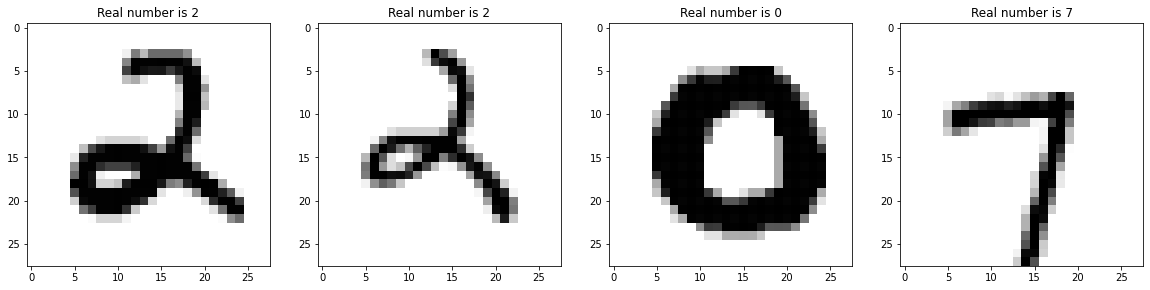

In [14]:
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)
# print(X_train__.shape)

fig, axis = plt.subplots(1, 4, figsize=(20,10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title=f'Real number is {digit}')

### Normalization

In [15]:
mean = np.mean(X_train)
std = np.std(X_train)

def standardize(x):
    return (x-mean)/std

In [16]:
epochs = 50
batch_size = 64

### CNN

- 32 filters for the first 2 conv2D layers
- 64 filters for the two second layers
- 127 filters for the two third layers
- 256 filters for the last layer

In [17]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


### Data Augmentation

In [18]:
datagen = ImageDataGenerator(
    featurewise_center = False,             # set input mean to 0 over the dataset
    samplewise_center = False,              # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,   # divide each input by its std
    zca_whitening = False,                  # apply ZCA whitening
    rotation_range = 10,                    # randomly rotate images in the range (d degreees, 0 to 180)
    zoom_range = 0.1,                       # randomly zoom image
    width_shift_range = 0.1,                # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,               # randomly shift images vertically (fraction of total height)
    horizontal_flip = False,                # randomly flip images
    vertical_flip = False                   # randomly flip images
)

# datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=batch_size)
test_gen = datagen.flow(X_test, y_test, batch_size=batch_size)

In [ ]:
# model.fit(X, y, batch_size=batch_size, validation_split=0.2, epochs=10)

In [19]:
history = model.fit_generator(train_gen,
                              epochs=epochs,
                              steps_per_epoch=X_train.shape[0]//batch_size,
                              validation_data=test_gen,
                              
                              validation_steps=X_test.shape[0]//batch_size)

C:\Users\Scott\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
590/590 [==============================] - 203s 305ms/step - loss: 0.3103 - accuracy: 0.9004 - val_loss: 0.0899 - val_accuracy: 0.9731
Epoch 2/50
590/590 [==============================] - 186s 316ms/step - loss: 0.0720 - accuracy: 0.9777 - val_loss: 0.0606 - val_accuracy: 0.9834
Epoch 3/50
590/590 [==============================] - 179s 304ms/step - loss: 0.0543 - accuracy: 0.9818 - val_loss: 0.0494 - val_accuracy: 0.9846
Epoch 4/50
590/590 [==============================] - 178s 301ms/step - loss: 0.0501 - accuracy: 0.9851 - val_loss: 0.0581 - val_accuracy: 0.9832
Epoch 5/50
590/590 [==============================] - 175s 296ms/step - loss: 0.0410 - accuracy: 0.9873 - val_loss: 0.0556 - val_accuracy: 0.9853
Epoch 6/50
590/590 [==============================] - 178s 301ms/step - loss: 0.0370 - accuracy: 0.9885 - val_loss: 0.0495 - val_accuracy: 0.9849
Epoch 7/50
590/590 [==============================] - 172s 292ms/step - loss: 0.0377 - accuracy: 0.9885 - val_loss: 0.0568 -

### Plot CNN Model

In [22]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### Evalute the model

#### Training and validation curves

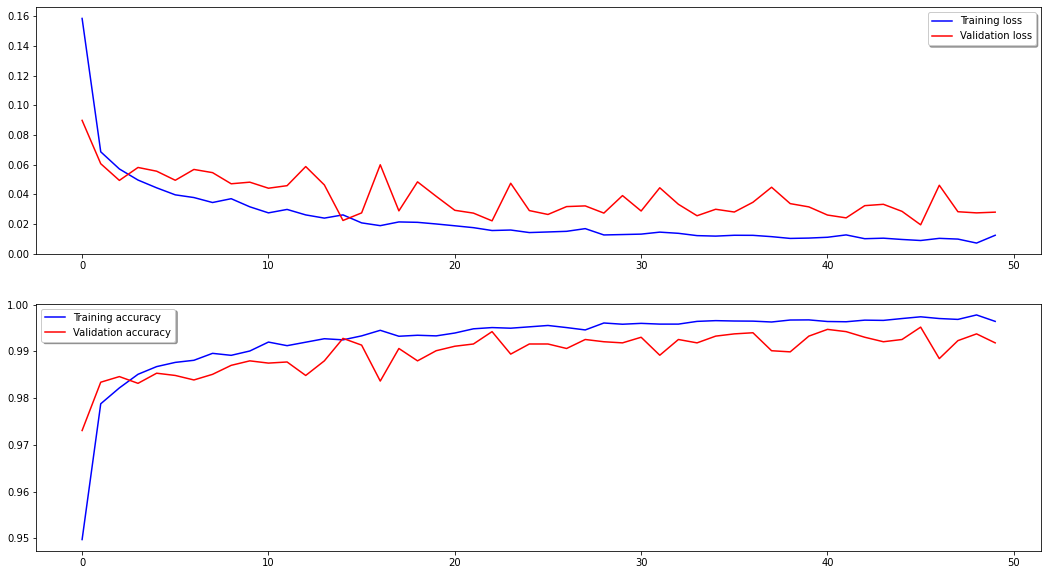

In [24]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1, figsize=(18,10))
ax[0].plot(history.history['loss'], color='b', label='Training loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation loss', axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
legend = ax[1].legend(loc='best', shadow=True)

#### Confusion Matrix

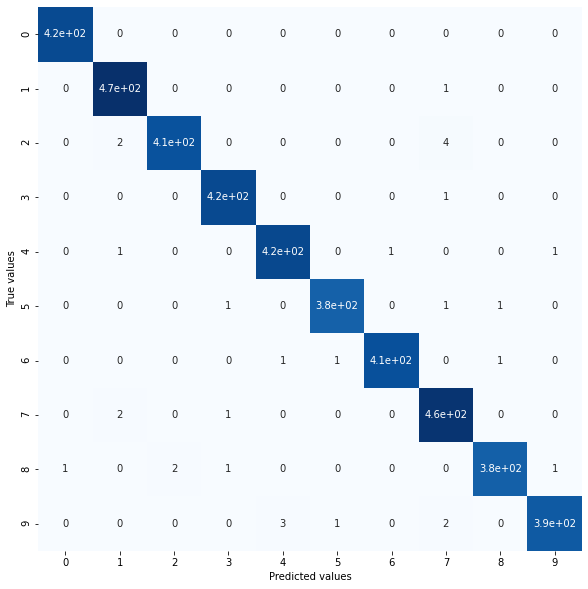

In [26]:
fig = plt.figure(figsize=(10,10))

y_pred = model.predict(X_test)

Y_pred = np.argmax(y_pred, 1) # Decode predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.show()

### Prediction and submission

#### Prediction validation results

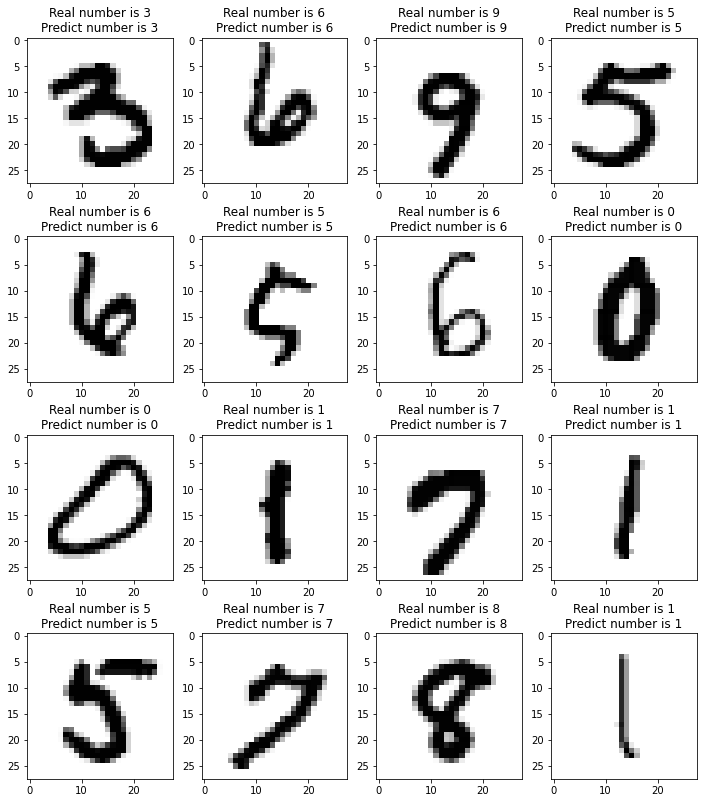

In [28]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title=f'Real number is {y_test[i].argmax()}\nPredict number is {y_pred[i].argmax()}')

Submission

In [29]:
pred = model.predict_classes(test_x, verbose=1)

C:\Users\Scott\AppData\Roaming\Python\Python39\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


875/875 [==============================] - 33s 37ms/step


In [32]:
sub['Label'] = pred
sub.to_csv('CNN_keras_sub.csv', index=False)
sub.head()

,ImageId,Label,label
0,1,2,2
1,2,0,0
2,3,9,9
3,4,0,0
4,5,3,3
